In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd 

In [9]:
labels_df = pd.read_csv("data/labels.csv")
labels_df['id'] = labels_df['id'] + ".jpg" 
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


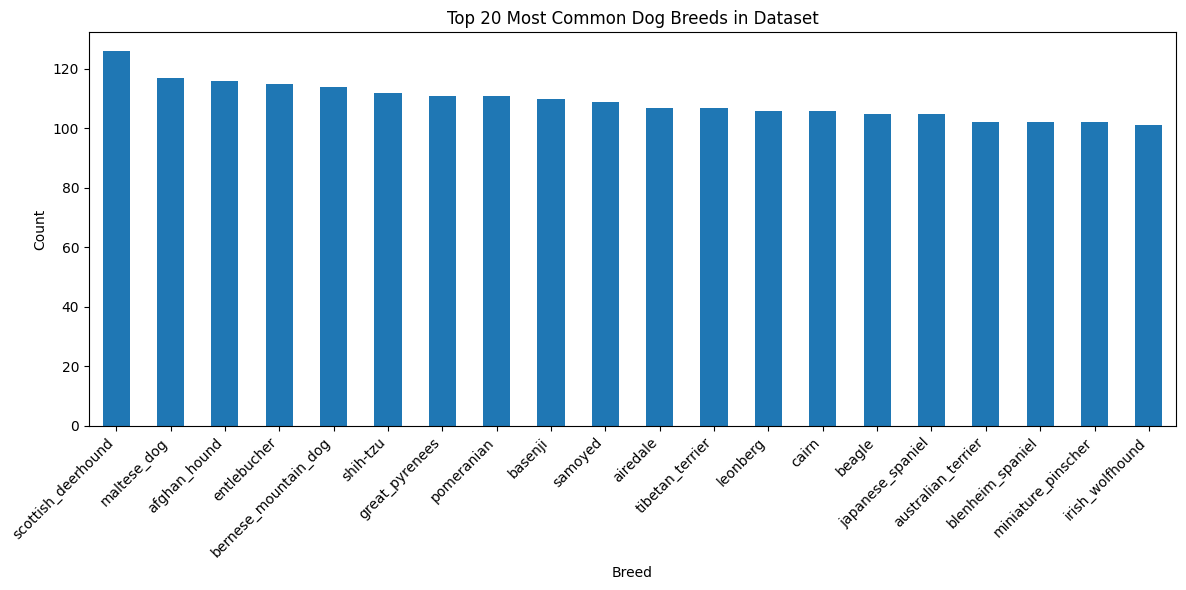

In [4]:
breed_counts = labels_df['breed'].value_counts()

plt.figure(figsize=(12, 6))
breed_counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Dog Breeds in Dataset")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_20_breeds.png")

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(labels_df, test_size=0.3, stratify=labels_df['breed'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['breed'], random_state=42)


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load and prepare labels
labels_df = pd.read_csv("data/labels.csv")

if not labels_df['id'].iloc[0].endswith('.jpg'):
    labels_df['id'] = labels_df['id'] + ".jpg"

print(f"Dataset loaded: {labels_df.shape[0]} samples, {labels_df['breed'].nunique()} breeds")

# Split the data
train_df, temp_df = train_test_split(
    labels_df, 
    test_size=0.3, 
    stratify=labels_df['breed'], 
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['breed'], 
    random_state=42
)

print(f"Data split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Image data generators
SIZE = (350, 350)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
image_dir = "data/train/"
SIZE = (350, 350)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Data generators ready! Classes: {len(train_generator.class_indices)}")

def create_model(num_classes):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(350, 350, 3)
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile model
model = create_model(len(train_generator.class_indices))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created and compiled successfully!")

Dataset loaded: 10222 samples, 120 breeds
Data split - Train: 7155, Val: 1533, Test: 1534
Found 7155 validated image filenames belonging to 120 classes.
Found 1533 validated image filenames belonging to 120 classes.
Found 1534 validated image filenames belonging to 120 classes.
Data generators ready! Classes: 120
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2025-06-04 13:57:16.923580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-04 13:57:16.925312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


83683744/83683744 [==============================] - 4s 0us/step
Model created and compiled successfully!


In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [16]:
# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=5,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5


2025-06-04 13:58:14.022941: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-06-04 13:58:15.277495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - ETA: 0s - loss: 1.5456 - accuracy: 0.6546

2025-06-04 14:03:14.767699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.38708, saving model to model.keras
223/223 [==============================] - 365s 2s/step - loss: 1.5456 - accuracy: 0.6546 - val_loss: 0.3871 - val_accuracy: 0.8983
Epoch 2/5
223/223 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.8338
Epoch 2: val_loss improved from 0.38708 to 0.32835, saving model to model.keras
223/223 [==============================] - 480s 2s/step - loss: 0.5455 - accuracy: 0.8338 - val_loss: 0.3283 - val_accuracy: 0.8996
Epoch 3/5
223/223 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8579
Epoch 3: val_loss did not improve from 0.32835
223/223 [==============================] - 659s 3s/step - loss: 0.4570 - accuracy: 0.8579 - val_loss: 0.3370 - val_accuracy: 0.8930
Epoch 4/5
223/223 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8628
Epoch 4: val_loss improved from 0.32835 to 0.31047, saving model to model.keras
223/223 [==========================

In [17]:
score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

48/48 [==============================] - 103s 2s/step - loss: 0.3174 - accuracy: 0.9009
Test loss: 0.3173796534538269
Test accuracy: 0.9009126424789429


In [23]:
import numpy as np
import pandas as pd

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

y_pred_breeds = [class_names[idx] for idx in y_pred_classes]
y_true_breeds = [class_names[idx] for idx in test_generator.classes]

image_ids = test_generator.filenames

results_df = pd.DataFrame({
    'imageID': image_ids,
    'predicted_class': y_pred_breeds,
    'actual_class': y_true_breeds
})

results_df.head()

48/48 [==============================] - 58s 1s/step


,imageID,predicted_class,actual_class
0,c6ab645e969263618b547ff66fd19d1f.jpg,brabancon_griffon,brabancon_griffon
1,66b1a3eb90d750b8739cbd6e74db13cf.jpg,gordon_setter,gordon_setter
2,12fe7ed6bd250509b131d245551b06f6.jpg,tibetan_terrier,tibetan_terrier
3,4b691c6936f4292697c85683f6a35aad.jpg,bluetick,bluetick
4,520b060d394dc47785d2eef1b627b895.jpg,briard,briard



Predictions for test.jpeg:
----------------------------------------
1. French Bulldog: 99.38%
2. Pug: 0.24%
3. Boxer: 0.12%
4. Staffordshire Bullterrier: 0.10%
5. Bull Mastiff: 0.06%


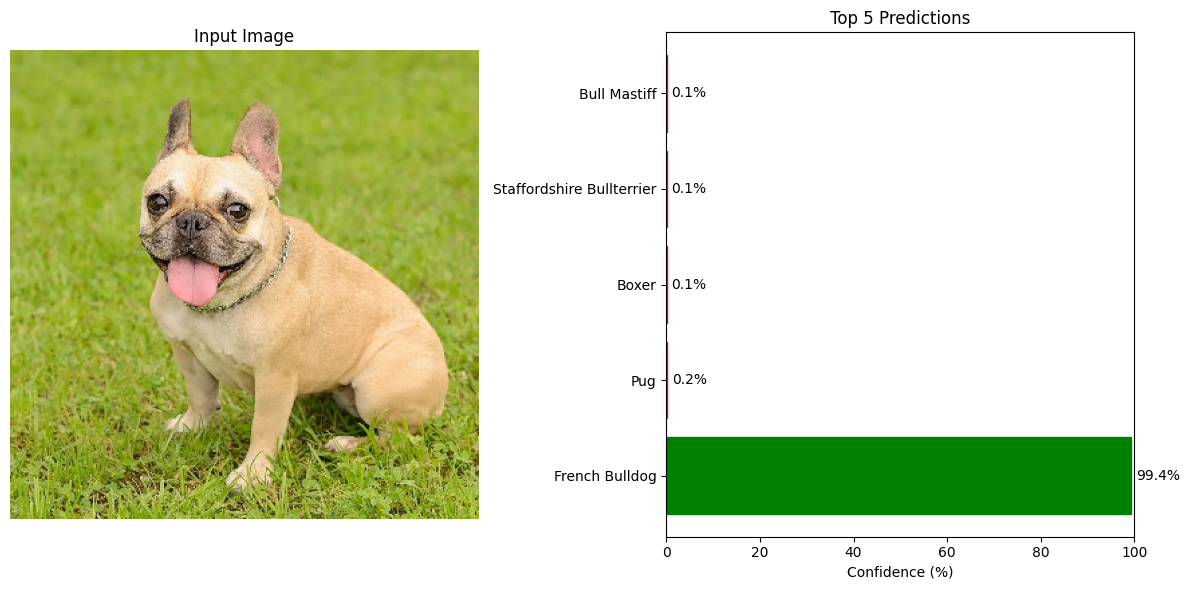

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
import cv2
from PIL import Image

def predict_dog_breed(model, img_path, class_indices, top_k=5):
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    try:
        img = image.load_img(img_path, target_size=(350, 350))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        predictions = model.predict(img_array, verbose=0)
        
        top_indices = np.argsort(predictions[0])[::-1][:top_k]
        top_predictions = []
        
        for i in top_indices:
            breed = idx_to_class[i]
            confidence = predictions[0][i] * 100
            top_predictions.append((breed, confidence))
        
        return top_predictions, img
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

def visualize_prediction(img_path, predictions, img):
    plt.figure(figsize=(12, 6))
    
    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')
    
    # Display predictions
    plt.subplot(1, 2, 2)
    breeds = [pred[0].replace('_', ' ').title() for pred in predictions]
    confidences = [pred[1] for pred in predictions]
    
    y_pos = np.arange(len(breeds))
    bars = plt.barh(y_pos, confidences)

    for i, bar in enumerate(bars):
        if confidences[i] > 50:
            bar.set_color('green')
        elif confidences[i] > 20:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    plt.yticks(y_pos, breeds)
    plt.xlabel('Confidence (%)')
    plt.title('Top 5 Predictions')
    plt.xlim(0, 100)
    
    for i, v in enumerate(confidences):
        plt.text(v + 1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()

img_path = 'test.jpeg'
predictions, img = predict_dog_breed(model, img_path, train_generator.class_indices)

if predictions:
    print(f"\nPredictions for {img_path}:")
    print("-" * 40)
    for i, (breed, confidence) in enumerate(predictions, 1):
        breed_name = breed.replace('_', ' ').title()
        print(f"{i}. {breed_name}: {confidence:.2f}%")
    
    visualize_prediction(img_path, predictions, img)
else:
    print("Failed to make prediction. Check your image path.")

In [26]:
results_df.to_csv('model_predictions5Epoch.csv', index=False)

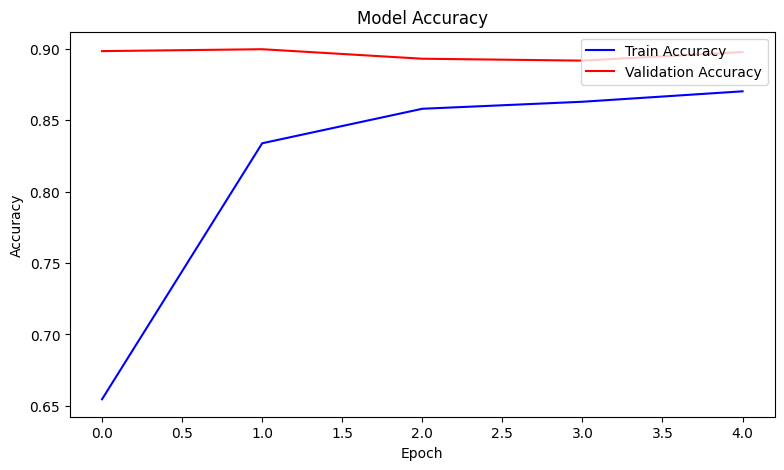

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')


plt.show()

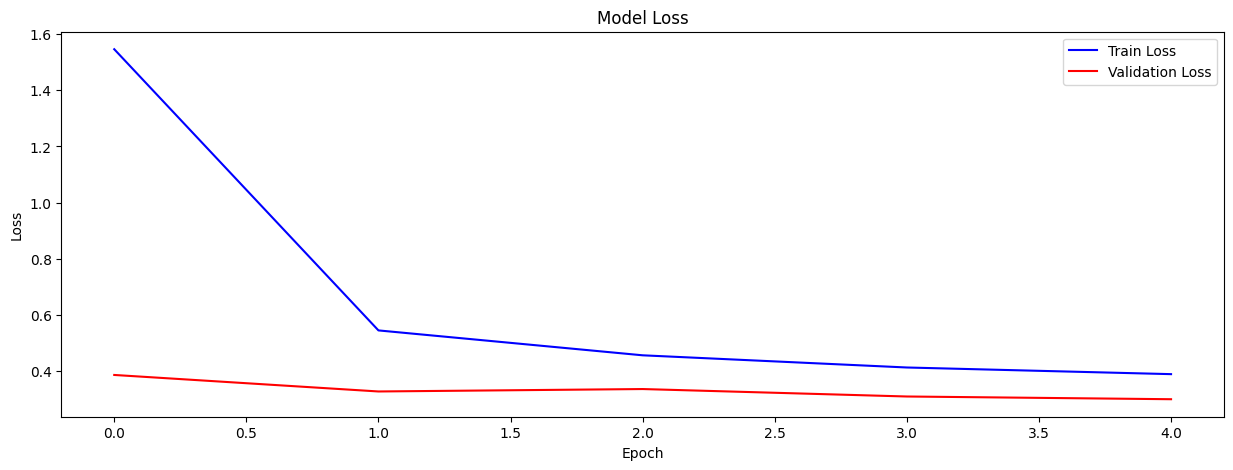

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

Getting predictions...


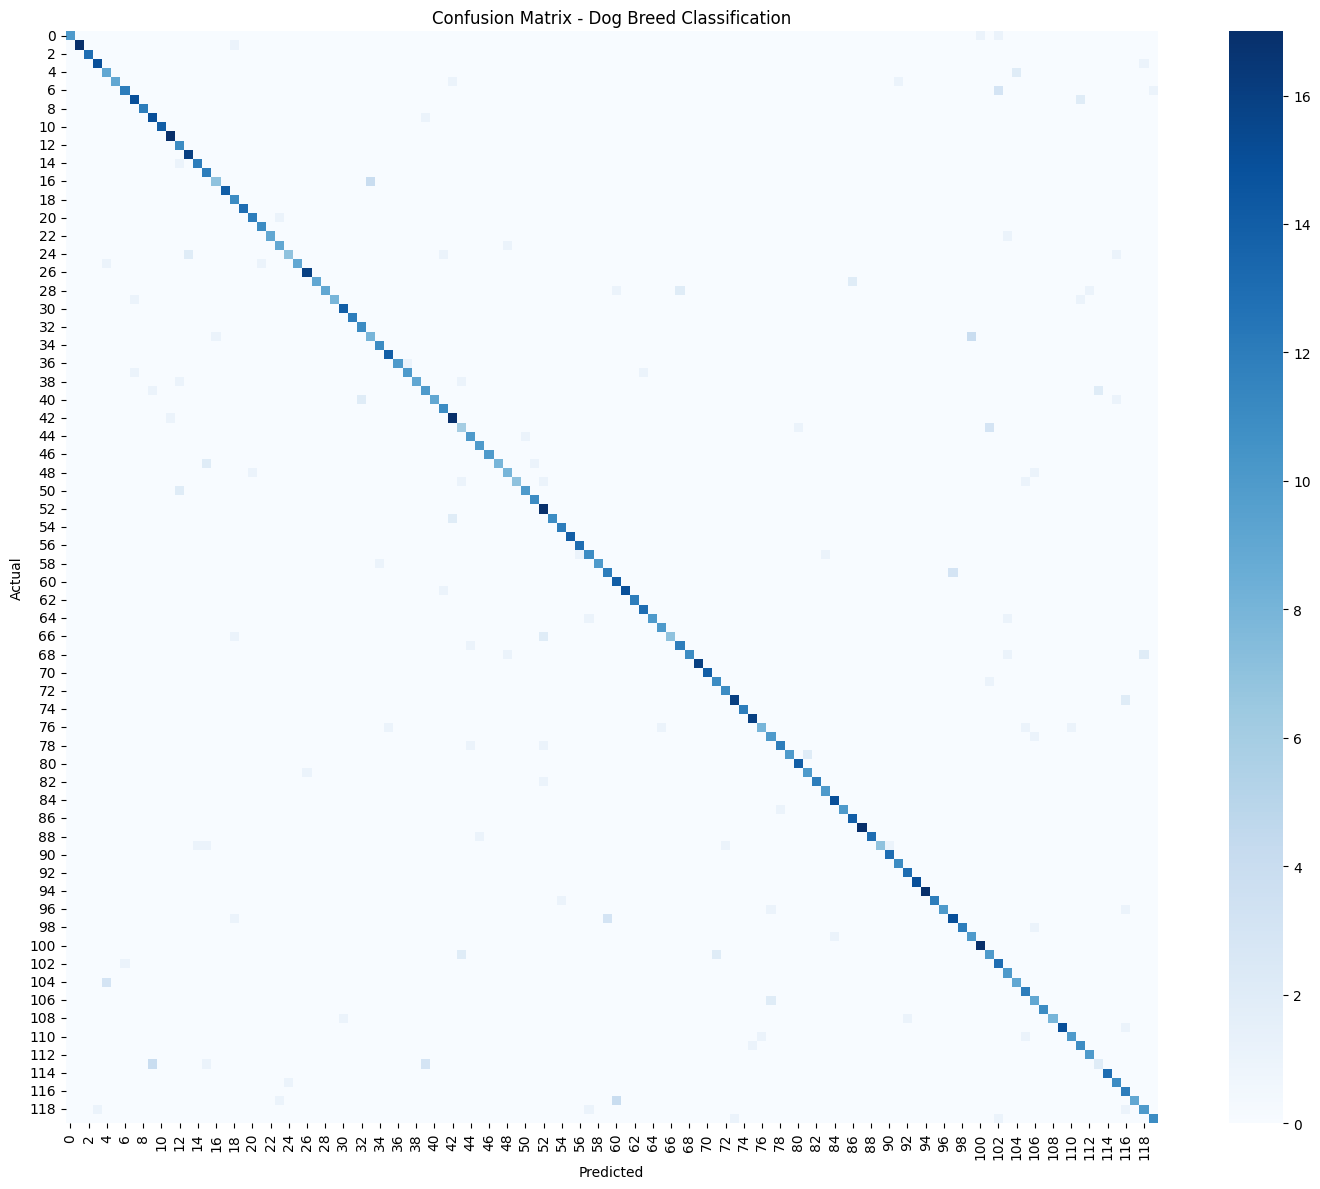

Test Accuracy: 0.9009
Total test samples: 1534
Number of classes: 120


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from test set
print("Getting predictions...")
test_generator.reset()
y_true = []
y_pred = []

# Go through all test batches
for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    pred_batch = model.predict(x_batch, verbose=0)
    
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(pred_batch, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, 
            annot=False,  # Too many classes for numbers
            cmap='Blues',
            square=True)

plt.title('Confusion Matrix - Dog Breed Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total test samples: {len(y_true)}")
print(f"Number of classes: {len(class_names)}")